In [1]:
# %matplotlib inline
%matplotlib widget
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import ipywidgets as wdg  # Using the ipython notebook widgets
import cv2

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [3]:
def axisEqual3D(ax, scale=[1,1,1]):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    mins = np.min(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    d = 0
    for ctr, dim in zip(centers, 'xyz'):
        if dim != 'z':
            getattr(ax, 'set_{}lim'.format(dim))(ctr - scale[d] * r, ctr + scale[d] * r)
        else:
            getattr(ax, 'set_{}lim'.format(dim))(mins[d] - 0.8 * scale[d] * r, mins[d] + 1.2 * scale[d] * r)
        d += 1
        
class Court3D:
    def __init__(self):
        
        # The corners must be in the order ADG (or some symmetry of it)
        lcorners = np.array([[0, 0], [1, 0], [0, 1], [1,1]])
        
        # ratios of the shorter side
        self.sr = [0, 1.5/20, 1./2, 1-1.5/20, 1]
        self.lr = [0, 2.5/44, 15.5/44, 1/2, 1-15.5/44, 1-2.5/44, 1]
        
        self.sr = [x * 6.1 for x in self.sr]
        self.lr = [x * 13.4 for x in self.lr]
                
        self.lines = []
        # Draw the horizontals
        for v in self.lr:
            for i in range(1, len(self.sr)):
                up, u = self.sr[i-1], self.sr[i]
                self.lines.append(((up, v), (u, v)))
        
        # Draw the verticals, but skip one line
        for u in self.sr:
            for i in range(1, len(self.lr)):
                vp, v = self.lr[i-1], self.lr[i]
                if (vp == 1./2 * 13.4 or v == 1./2 * 13.4) and u == 1./2 * 6.1:
                    continue
                self.lines.append(((u, vp), (u, v)))
                
        # The net
        self.left_post = [[0, self.lr[3], 0], [0, self.lr[3], 1.55]]
        self.right_post = [[6.1, self.lr[3], 0], [6.1, self.lr[3], 1.55]]
        self.net_line_top = [[0, self.lr[3], 1.55], [6.1, self.lr[3], 1.55]]
        self.net_line_bot = [[0, self.lr[3], 1.55 / 2.], [6.1, self.lr[3], 1.55 / 2.]]
        self.boundary = [[0, 0, 0], [6.1, 0, 0], [0, 13.4, 0], [6.1, 13.4, 0]]
        self.net = [self.left_post, self.right_post, self.net_line_top, self.net_line_bot]
    
    def draw_lines(self, fig):
        for line in self.lines:
            xline = [line[0][0], line[1][0]]
            yline = [line[0][1], line[1][1]]
            zline = [0, 0]
            
            fig.plot3D(xline, yline, zline, 'black', linewidth=2)
        
        # Draw vertical net
        for line in self.net:
            xline = [line[0][0], line[1][0]]
            yline = [line[0][1], line[1][1]]
            zline = [line[0][2], line[1][2]]
            
            fig.plot3D(xline, yline, zline, 'gray')
        
court3d = Court3D()

In [4]:
import os
import pandas as pd
import numpy as np
import cv2
import errno

from ai_badminton.trajectory import Trajectory
from ai_badminton.hit_detector import AdhocHitDetector, MLHitDetector
from ai_badminton.pose import Pose, read_player_poses, process_pose_file
from ai_badminton.court import Court, read_court
from ai_badminton.video_annotator import annotate_video
from ai_badminton.shots import *
from ai_badminton.rally_reconstructor import *

In [101]:
base_dir = '/home/code-base/user_space/mined_data/output'
match_name = 'super-trickshot-lin-dan-vs-peter-gade-highlights-last-match-shuttle-amazing-cg-3m4p-r0k'
rally = 'rally42'

cap = cv2.VideoCapture('%s/%s/rally_video/%s.mp4' % (base_dir, match_name, rally))
_, frame = cap.read()

court_pts = read_court('%s/%s/court/%s.out' % (base_dir, match_name, match_name))
corners = [court_pts[1], court_pts[2], court_pts[0], court_pts[3]]
pole_tips = [court_pts[4], court_pts[5]]
court = Court3D(corners, pole_tips)
trajectory = Trajectory(
    '%s/%s/ball_trajectory/%s_ball.csv' % (base_dir, match_name, rally),
    interp=False
)

hits = pd.read_csv('%s/%s/shot/%s_hit.csv' % (base_dir, match_name, rally))
poses = read_player_poses('%s/%s/poses/%s' % (base_dir, match_name, rally))


In [102]:
# Create a graph for each observation
from collections import defaultdict
import copy

class TrajectoryFilter:
    def __init__(self, wtime=4, wpixel=60, wcomp=5):
        self.wtime = wtime
        self.wpixel = wpixel
        self.wcomp = wcomp
        
    def create_graph(self, trajectory):
        graph = defaultdict(list)
        points = list(zip(trajectory.X, trajectory.Y))
        
        for i in range(len(points)):
            # Search back and forth Lt steps and find points within eps
            # Only need to iterate on backwards range since we add the edges bidirectionally
            for k in range(max(0, i-self.wtime), i):
                diff = np.array(points[i]) - np.array(points[k])
                if np.all(np.abs(diff) < self.wpixel):
                    graph[i].append(k)
                    graph[k].append(i)
        return graph            
    
    def find_components(self, graph):
        # Now find the components of the graph
        seen = {}
        def dfs(v, num):
            stack = [v]
            seen[v] = num
            comp = [v]
            while len(stack):
                v = stack.pop()
                if v not in graph:
                    continue
                for w in graph[v]:
                    if w not in seen:
                        seen[w] = num
                        stack.append(w)
                        comp.append(w)
            return comp

        compid = 0
        for v in graph:
            if v not in seen:
                comp = dfs(v, compid)
                compid += 1

        components = defaultdict(list)
        for v in graph:
            components[seen[v]].append(v)
        return components
    
    def filter_trajectory(self, trajectory):
        graph = self.create_graph(trajectory)
        components = self.find_components(graph)
        
        sorted_comps = []
        for compv in components.values():
            if len(compv) >= self.wcomp:
                sorted_comps.append((-len(compv), compv))
        sorted_comps.sort()
        
        # Iterate through components in decreasing weight, doing linear interpolation / collision checking with other comps
        L = len(trajectory.X)
        done = np.array([0] * L)
        filtered = []
        for score, comp in sorted_comps:
            m, M = min(x for x in comp), max(x for x in comp)
            if any(done[m:M+1]):
                continue
            done[m:M] = 1
            
            comp = sorted(comp)
            for t in comp:
                filtered.append((t, (trajectory.X[t], trajectory.Y[t])))
        
        new_traj = copy.deepcopy(trajectory)
        new_traj.X, new_traj.Y = [0] * L, [0] * L
        cnt = 0
        for i, p in sorted(filtered):
            while cnt < i:
                cnt += 1
            new_traj.X[i] = p[0]
            new_traj.Y[i] = p[1]
            cnt += 1
        return new_traj

In [103]:
traj_filter = TrajectoryFilter()
new_traj = traj_filter.filter_trajectory(trajectory)

In [104]:
trajectory.X = new_traj.X
trajectory.Y = new_traj.Y

In [105]:
hit_frame, who_hit = [], []
L = hits.hit.shape[0]
for i in range(L):
    if hits.hit[i]:
        hit_frame.append(i)
        who_hit.append(hits.hit[i])

In [106]:
reconstructor = RallyReconstructor(
    court,
    poses,
    trajectory,
    hits
)

In [107]:
results = reconstructor.reconstruct(30)

100%|██████████| 14/14 [01:15<00:00,  5.41s/it]


In [108]:
len(trajectory.X)

459

In [109]:
import copy
X = np.array([court.project_uv(x) for x in results])
copyTraj = copy.deepcopy(trajectory)
copyTraj.X[0:] = X[:,0]
copyTraj.Y[0:] = X[:,1]

In [111]:
annotate_video(
    cap,
    court.court2d,
    poses,
    copyTraj
)

  0%|          | 0/428 [00:00<?, ?it/s]

In [35]:
trajectory.X

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 711.0,
 698.0,
 683.0,
 682.0,
 671.0,
 656.0,
 642.0,
 631.0,
 617.0,
 618.0,
 606.0,
 595.0,
 582.0,
 571.0,
 560.0,
 561.0,
 550.0,
 538.0,
 527.0,
 516.0,
 506.0,
 508.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 455.0,
 465.0,
 471.0,
 471.0,
 476.0,
 481.0,
 483.0,
 486.0,
 490.0,
 491.0,
 493.0,
 496.0,
 498.0,
 501.0,
 503.0,
 503.0,
 506.0,
 506.0,
 508.0,
 530.0,
 0.0,
 551.0,
 563.0,
 0.0,
 0.0,
 0.0,
 623.0,
 626.0,
 638.0,
 653.0,
 665.0,
 676.0,
 691.0,
 691.0,
 701.0,
 711.0,
 722.0,
 733.0,
 743.0,
 743.0,
 751.0,
 761.0,
 753.0,
 0.0,
 732.0,
 732.0,
 723.0,
 713.0,
 708.0,
 701.0,
 696.0,
 696.0,
 690.0,
 685.0,
 678.0,
 672.0,
 666.0,
 666.0,
 661.0,
 656.0,
 651.0,
 648.0,
 643.0,
 645.0,
 638.0,
 0.0,
 632.0,
 631.0,
 0.0,
 0.0,
 0.0,
 620.0,
 0.0,
 0.0,
 656.0,
 656.0,
 668.0,
 678.0,
 691.0,
 701.0,
 710.0,
 711.0,
 0.0,
 726.0,
 736.0,
 746.0,
 0.0,
 755.0,
 761.0,
 768.0,
 776.0,
 7

In [22]:
# num_matches = 1
# matches = list('match' + str(i) for i in range(1, num_matches+1))

# manual_label = {
#     ('match1', '1_02_04'): 2,
#     ('match1', '1_06_08'): 1,
#     ('match1', '1_02_02'): 1,
#     ('match1', '1_02_01'): 2,
#     ('match1', '1_03_04'): 2,
#     ('match1', '1_02_03'): 1,
#     ('match3', '1_08_10'): 2,
#     ('match8', '3_02_00'): 2,
# }

# for match in matches:
#     for video in os.listdir('/home/code-base/scratch_space/data/%s/rally_video/' % match):
#         cap = cv2.VideoCapture('/home/code-base/scratch_space/data/%s/rally_video/%s' % (match, video))
#         _, frame = cap.read()
#         rally, _ = os.path.splitext(video)
#         court_pts = read_court('/home/code-base/scratch_space/data/%s/court/%s.out' % (match, rally))
#         corners = [court_pts[1], court_pts[2], court_pts[0], court_pts[3]]
#         court = Court(corners)
#         trajectory = Trajectory(
#             '/home/code-base/scratch_space/data/%s/ball_trajectory/%s_ball.csv' % (match, rally),
#             interp=False
#         )
        
#         hits = pd.read_csv('/home/code-base/scratch_space/data/%s/shot/%s_hit.csv' % (match, rally))
#         poses = read_player_poses('/home/code-base/scratch_space/data/%s/poses/%s' % (match, rally))
        
#         # Identify first hit by distance to pose
#         # and then alternate hits
#         def dist_to_pose(pose, p):
#             pose = pose.reshape(17, 2)
#             p = p.reshape(1, 2)
#             D = np.sum((pose - p) * (pose - p), axis=1)
#             return min(D)
        
#         hits = np.array(hits.hit.to_numpy())
#         # Majority vote for who started the rally
#         # If hit number is odd, then whoever started the rally
#         # is the opposite of whoever was detected.
#         votes = [0, 0]
#         best_dist = [1e99, 1e99]
#         nhit = 0
#         for i in range(hits.shape[0]):
#             if not hits[i]:
#                 continue
            
#             p = np.array([trajectory.X[i], trajectory.Y[i]])
#             db = dist_to_pose(poses[0].values[i], p)
#             dt = dist_to_pose(poses[1].values[i], p)
#             person = 0
#             if db < dt:
#                 person = 1
#             else:
#                 person = 2
            
#             if nhit % 2:
#                 person = 3 - person
                
#             votes[person - 1] += 1
#             best_dist[person - 1] = min(best_dist[person - 1], min(db, dt))
            
#             nhit += 1
            
#         last = 2 if votes[0] > votes[1] else 1
#         if (match, rally) in manual_label:
#             last = 3 - manual_label[match, rally]
            
#         for i in range(hits.shape[0]):
#             if not hits[i]:
#                 continue
                
#             hits[i] = 3 - last
#             last = hits[i]
                
#         # Generate arrays of which frames the shuttles were hit and who hit it
#         hit_frame, who_hit = [], []
#         L = hits.shape[0]
#         for i in range(L):
#             if hits[i]:
#                 hit_frame.append(i)
#                 who_hit.append(hits[i])
                
#         # Assume the rally ends 4 frames from the end
#         hit_frame.append(L - 4)
#         who_hit.append(3)
#         break

In [23]:
# # Last two are poles
# image_points = corners + [[356, 356], [923, 356], [640, 642], [637, 459]]
# object_points = court3d.boundary + court3d.net_line_top + [[3.05, 0.76, 0], [3.05, 6.7+1.98, 0]]
# # distGuess = np.zeros(4)
# # ret, mtx, distCoeffs, rvecs, tvecs = \
# # cv2.calibrateCamera([object_points], [image_points], (frame.shape[0], frame.shape[1]), None, distGuess)

# # rotation_mat = np.zeros(shape=(3, 3))
# # R = cv2.Rodrigues(rvecs[0], rotation_mat)[0]
# # P = np.column_stack((np.matmul(mtx,R), tvecs[0]))

# N = len(image_points)
# A = np.zeros((2 * N, 11))
# y = np.zeros((2*N, 1))
# for i in range(N):
#     for j in range(2):
#         st = 4 if j > 0 else 0
#         z = np.array(object_points[i])
#         A[2*i+j, st:st+3] = z
#         A[2*i+j, st+3] = 1
#         A[2*i+j, -3:] = -image_points[i][j] * z
#         y[2*i+j] = image_points[i][j]

# c, _, _, _ = np.linalg.lstsq(A, y)
# # c = np.linalg.solve(A.T @ A, A.T @ y)
# print(c)
# C = np.zeros((3, 4))
# for i in range(3):
#     for j in range(4):
#         if i == 2 and j == 3:
#             C[i,j] = 1
#         else:
#             C[i,j] = c[4 * i + j]
# camProj = np.array(C)

# Z = C @ np.vstack([np.array([[3.05, 6.7, 0], [0.45, 6.7+1.98, 0]] + object_points).T, np.ones((1,N+2))])
# print(Z[:2] / Z[2])
# print(image_points)
# print(object_points)
# print(np.linalg.norm(A@c - y))

# Court().manually_label(frame)

# 3D trajectory reconstruction from Chen et al.

In [24]:
# # Be lazy and try to fit a degree (d-1) poly solution for the trajectory
# # Fitting the solution of an air-resisted particle might require some non-linear opt
# d = 3
# A, y = [], []
# #          these are params (we know last row is [1 0 0 0 ...])
# # [3 x 4] [4 x d] [d x N] 
# # [3 x 4] [4 x N]
# # [3 x N]
# # but we sort of know last row
# # or..
# # [2N x 3d] [3d x 1] = [2N x 1]
# # [2N x 4] [4 x 3d] [3d x 1] = [2N x 1]
# # Basically...
# # [X, Y, Z, 1] = [4N x 4d] [4d x 1]
# # C [X Y Z 1] = [U V W]
# # Ca [X Y Z] = [U'Cb V'Cb]
# # [Ca repeated on the diagonal] [3N x 3d] [3d x 1]
# # [2N x 3N] [3N x 3d]

# P = np.zeros((2*N, 3*N))
# T = np.zeros((3*N, 3*d))
# y = np.zeros((2*N, 1))
# for r in range(N):
#     i = r + hit_frame[fid]
#     if trajectory.X[i] != trajectory.X[i]:
#         print('Skipped', i)
#         continue
#     t = float(r) / fps
#     z = np.zeros((1, d))
#     for j in range(d):
#         z[0, j] = pow(t, j)
#     T[3*r, 0:d] = T[3*r+1, d:2*d] = T[3*r+2, 2*d:3*d] = z
    
#     U, V = trajectory.X[i], trajectory.Y[i]
#     D = np.array(C[:2, :3])
#     D[0, :3] -= U * C[2,:3]
#     D[1, :3] -= V * C[2,:3]
#     P[2*r:2*r+2, 3*r:3*r+3] = D 
    
#     y[2*r] = U - C[0,3]
#     y[2*r+1] = V - C[1,3]
    
# A = np.zeros((2*N+7, 3*d))
# yf = np.zeros((2*N+7, 1))
# A[:2*N, :3*d] = P @ T
# yf[:2*N] = y

# # Assumes hitting from bottom player to top
# # also add some physics constraints
# A[2*N, 0] = 1
# yf[2*N] = locations[0][0]

# A[2*N+1, d] = 1
# yf[2*N+1] = locations[0][1]

# A[2*N+2, 2] = 1
# yf[2*N+2] = 0

# A[2*N+3, 0:d] = z
# yf[2*N+3] = locations[1][0]

# A[2*N+4, d:2*d] = z
# yf[2*N+4] = locations[1][1]

# A[2*N+5, d+2] = 1
# yf[2*N+5] = 0

# # A[2*N+6, 2*d] = 1
# # yf[2*N+6] = player_heights[0]

# # A[2*N+7, 2*d:] = z
# # yf[2*N+7] = player_heights[1]

# A[2*N+6, 2*d+2] = 1
# yf[2*N+6] = -9.8/2

# wt = 1e2
# W = np.identity(2*N+7)
# for j in range(7):
#     W[2*N+j, 2*N+j] = wt
# # W[2*N+2] = W[2*N+5] = wt**0.5

# series, _, _, _ = np.linalg.lstsq(W @ A, W @ yf)
# np.linalg.norm((A @ series) - yf)
# series

In [25]:
# est_traj = (T @ series).reshape(N, 3)
# for i in range(N-1):
#     xline = est_traj[i:i+2, 0]
#     yline = est_traj[i:i+2, 1]
#     zline = est_traj[i:i+2, 2]
#     ax.plot3D(xline, yline, zline, 'blue')
    
# q = (A @ series)[:2*N]
# for i in range(N):
#     q[2*i] += C[0, 3]
#     q[2*i+1] += C[1, 3]
# q.reshape(N, 2)

# Draw court on 3d plot

In [26]:
def draw_rally(hit_id, ax):
    frame_id = [hit_frame[hit_id], hit_frame[hit_id+1]]
    # Get poses from frame
    # TTY, Yamaguchi
    player_heights = [1.8, 1.8]
    locations = []
    for j in range(2):
        xy = poses[(j+hit_id+1)%2].iloc[frame_id[j]].to_list()
        pose = Pose()
        pose.init_from_kparray(xy)

        mid_pt = pose.get_base()
        court_pt = court.pixel_to_court(mid_pt)
        court_pt = [court_pt[0] * 6.1, court_pt[1] * 13.4]

        img = cv2.imread('player.png', cv2.IMREAD_UNCHANGED)
        img[img > 0] = 1

        scale_percent = 10 # percent of original size
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)

        x_vals = np.where(np.min(img[:,:,0], axis=0) == 0)[0]
        y_vals = np.where(np.min(img[:,:,0], axis=1) == 0)[0]

        x_to_y = (max(x_vals) - min(x_vals) + 1.) / (max(y_vals) - min(y_vals) + 1.)
        img = img[min(x_vals):max(x_vals)+1, min(y_vals):max(y_vals)+1, :]

        # resize image
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        x0, z0 = np.mgrid[0:img.shape[0], 0:img.shape[1]]

        # Rescale to proportions of average human
        if hit_id % 2:
            sgn = 1 if j == 1 else -1
        else:
            sgn = -1 if j == 1 else 1
        x, z = sgn * (z0 / img.shape[1]- 0.5) * player_heights[j] * x_to_y, player_heights[j] - x0 / img.shape[0] * player_heights[j]
        y = np.ones(x.shape) * court_pt[1]

        ax.plot_surface(x + court_pt[0], court_pt[1], z, rstride=5, cstride=5,
                        facecolors=img)

        locations.append(court_pt)
    return locations

# Non-linear models for trajectory estimation

In [8]:
"""
Our model:

v = (vx, vy, vz)
g = (0, 0, -9.8) * frame_rate_adjustment
dv/dt = g - C * |v| v

Second order differential equation.
What we don't know:
- C (a coefficient encompassing drag)
- Initial velocity and location

If I know v0, x0, and C, I can calculate the forward difference across the time steps until I get to the end
Then I can try to minimize a least squares objective over the observations.

Calculation of time required:
    - Avg number of frames ~20
    - Subdivide into timesteps of 1/10th-frame
    => Function evaluation requires ~200 iterations

Initial guess for solution:
    - td = time diff
    - 0 = hit_height + vz * td - 1/2 g td^2
    - vz = g td/2
    - D = diff in pose positions
    - (vx, vy) = D / td
    - C = 1/2 rho A C_d / m
        = (1/2) * 1.2 * pi * (0.035^2) * 0.47 / 0.005
        ~ 0.2
"""

if 0 not in hit_frame:
    hit_frame = [0] + hit_frame
fps = cap.get(cv2.CAP_PROP_FPS)
player_heights = [1.63, 1.56]
def infer_and_plot_trajectory(hit_id, locations, ax):
    N = hit_frame[hit_id+1] - hit_frame[hit_id]

    substeps = 10
    td = float(N) / fps
    D = np.array(locations[1]) - np.array(locations[0])
    g = np.array([0, 0, -9.8])

    xg = np.array(locations[0] + [player_heights[0]])
    vg = np.array([0,0,0])#np.array([x for x in D / td] + [9.8 * td / 2 - 1. / td])
    Cg = 0.2
    
    initg = np.concatenate([xg, vg, np.array([Cg])])
    bounds = [(0, 6.1), (0, 13.4 / 2), (0.1, 3), (-100, 100), (-100, 100), (0, 100), (0, 1)]
    if hit_id % 2 == 0:
        bounds[1] = (13.4 / 2, 13.4)
    norm_scale = np.linalg.norm(camProj[:3, :3], ord=2)

    def get_trajectory(p):
        x = np.array(p[:3])
        v = np.array(p[3:6])
        C = np.array(p[6])

        dt = 1. / (fps * substeps)
        res = []
        for t in range(substeps * N + 1):
            if t % substeps == 0:
                res.append(np.array(x))
            v += dt * (g - C * np.linalg.norm(v) * v)
            x += dt * v
        return res

    def f(p, debug=False):
        x = np.array(p[:3])
        v = np.array(p[3:6])
        C = np.array(p[6])

        out_loss, loss = 0, 0
        dt = 1. / (fps * substeps)
        tid = hit_frame[hit_id]
        pixel_err = 0
        for t in range(substeps * N + 1):
            if t % substeps == 0:
                q = camProj[:, :3] @ x + camProj[:, 3]
                z = q[:2] / q[2]
                if debug:
                    print(z)
                    pixel_err += np.linalg.norm(z - np.array([trajectory.X[tid], trajectory.Y[tid]]))
                loss += np.linalg.norm(z - np.array([trajectory.X[tid], trajectory.Y[tid]]))
                tid += 1

            x += dt * v
            v += dt * (g - C * np.linalg.norm(v) * v)

        drift_loss = np.linalg.norm(x[:2] - np.array(locations[1]))**2 + \
                    np.linalg.norm(p[:2] - np.array(locations[0]))**2
        
        # Project current trajectory until it lands. If its too far out, add a penalty
        xc = np.array(x)
        vc = np.array(v)

        while xc[2] > 0:
            xc += dt * vc
            vc += dt * (g - C * np.linalg.norm(vc) * vc)

        out_loss += 100 * max(0 - xc[0], xc[0] - 6.1, 0)**2
        out_loss += 100 * max(0 - xc[1], xc[1] - 13.4, 0)**2
        out_loss += 100 * max(xc[2] - 3, 0)**2

        if debug:
            print('Average pixel error:', pixel_err / N)
        return loss + norm_scale * (drift_loss**0.5 + out_loss**0.5)

    import scipy.optimize
    res = scipy.optimize.minimize(
        f, initg, bounds=bounds,
        method='SLSQP',
        options={
            'disp': None, 
            'maxls': 42, 
            'iprint': 99, 
            'gtol': 1e-09, 
            'eps': 1e-09, 
            'maxiter': 15000, 
            'ftol': 1e-09, 
            'maxcor': 30, 'maxfun': 35000}
    )
    # res = scipy.optimize.brute(
    #     f, ranges=bounds,
    #     disp=True,
    #     Ns=4,
    #     workers=8
    # )
    # res = scipy.optimize.differential_evolution(
    #     f, bounds=bounds, workers=-1, disp=True,
    #     maxiter=10000, popsize=100, init='random',
    #     atol=1e-6
    # )
    # res = scipy.optimize.dual_annealing(
    #     f, bounds
    # )
    # res = scipy.optimize.basinhopping(
    #     f, initg,
    #     disp=True
    # )
    # res = scipy.optimize.shgo(
    #     f, bounds
    # )
#     delta = 4 / 100
#     data = []
#     for i in range(100):
#         initg[2] = i * delta
#         data.append(f(initg))
#     plt.figure()
#     plt.plot(np.array(list(range(100)))*4/100, data)
#     plt.show()
    
    est_traj = np.array(get_trajectory(res.x))
    for i in range(N-1):
        xline = est_traj[i:i+2, 0]
        yline = est_traj[i:i+2, 1]
        zline = est_traj[i:i+2, 2]
        color = 'red' if hit_id % 2 else 'blue'
        if i != N-2:
            ax.plot3D(xline, yline, zline, color)
        else:
            a = Arrow3D(
                xline, yline, zline, mutation_scale=5, 
                lw=1, arrowstyle="-|>", color=color
            )
            ax.add_artist(a)
    print(res)
    return est_traj

# Set up basic court view

In [27]:
def reset_court_view(azim=-90, elev=6.729862676777941, dist=3, scale=[1.25, 0.85, 1]):
    fig = plt.figure()
    fig.subplots_adjust(left=-0.2, right=1.2, bottom=-0.2, top=1.2)
    ax = plt.axes(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    court3d.draw_lines(ax)
    axisEqual3D(ax, scale)
    ax.dist = dist
    return fig, ax

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
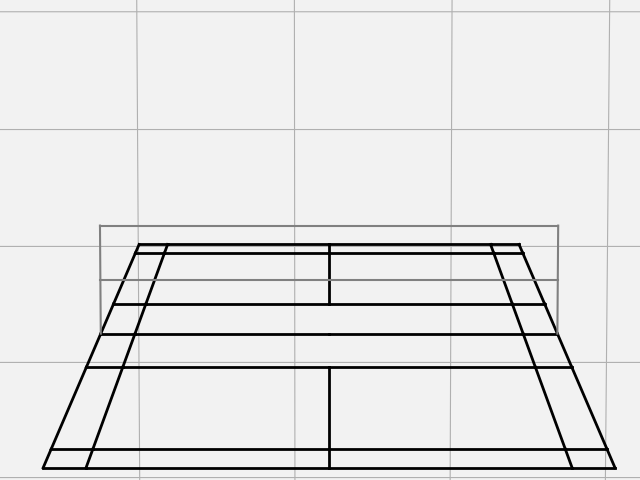

In [41]:
fig, ax = reset_court_view()

In [35]:
for i in range(1):
    locations = draw_rally(i, ax)
    infer_and_plot_trajectory(i, locations, ax)

NameError: name 'hit_frame' is not defined

# Multi-hit model

In [38]:
if 0 not in hit_frame:
    hit_frame = [0] + hit_frame
fps = cap.get(cv2.CAP_PROP_FPS)
player_heights = [1.63, 1.56]

def multi_hit_solve(
    hit_id=0, 
    num_hits=3, 
    start_x=None, 
    ax=None,
    fr_adjust=30./25
):
    def get_locations(start_id, num_hits):
        frame_id = hit_frame[start_id:start_id+num_hits+1]
        # Get poses from frame
        # TTY, Yamaguchi
        player_heights = [1.63, 1.56]
        locations = []
        for j in range(num_hits + 1):
            xy = poses[(j+hit_id+1)%2].iloc[frame_id[j]].to_list()
            pose = Pose()
            pose.init_from_kparray(xy)

            mid_pt = pose.get_base()
            court_pt = court.pixel_to_court(mid_pt)
            court_pt = [court_pt[0] * 6.1, court_pt[1] * 13.4]
            locations.append(court_pt)
        return locations

    N = hit_frame[hit_id+num_hits] - hit_frame[hit_id]

    substeps = 30
    # Multiply by 1.25 because video may have been sped up
    g = np.array([0, 0, -9.8])

    locations = get_locations(hit_id, num_hits)
    xg = np.array(locations[0] + [player_heights[0]])
    if start_x is not None:
        xg = np.array(start_x)
    vg = []
    for j in range(num_hits):
        td = fr_adjust * float(hit_frame[hit_id+j+1] - hit_frame[hit_id+j] + 1) / fps
        D = np.array(locations[j+1]) - np.array(locations[j])
        vh = np.array([x for x in D / td] + [9.8 * td / 2 - 1. / td])
        vg.append(vh)
    vg = np.concatenate(vg)
    Cg = 0.2

    initg = np.concatenate([xg, vg, np.array([Cg])])
    bounds = [(0, 6.1), (0, 13.4 / 2), (0.1, 6)] + [(-150, 150)] * (3*num_hits) +  [(0, 0.4)]
    if hit_id % 2 == 0:
        bounds[1] = (13.4 / 2, 13.4)
    norm_scale = np.linalg.norm(camProj[:3, :3], ord=2)

    def get_trajectory(p):
        x = np.array(p[:3])
        if start_x is not None:
            # TODO: Fix this ugly hack to enforce start positions
            x = np.array(start_x)
        v0 = np.array(p[3:-1]).reshape(num_hits, 3)
        C = np.array(p[-1])

        dt = fr_adjust * 1. / (fps * substeps)
        res = []

        tid = hit_frame[hit_id]
        vid, hid = 0, hit_id
        v = np.array(v0[vid])
        for t in range(substeps * N + 1):
            v += dt * (g - C * np.linalg.norm(v) * v)
            
            if t % substeps == 0:
                res.append(np.array(x))
                tid += 1
                if tid == hit_frame[hid + 1]:
                    hid += 1
                    vid += 1
                    if vid < num_hits:
                        v = np.array(v0[vid])
                        
            x += dt * v
            
        return res

    def f(p, debug=False):
        x = np.array(p[:3])
        if start_x is not None:
            # TODO: Fix this ugly hack to enforce start positions
            x = np.array(start_x)
        v0 = np.array(p[3:-1]).reshape(num_hits, 3)
        C = np.array(p[-1])
#         if True:
#             # TODO: Fix this ugly hack: enforce same drag coeff throughout all trajectories
#             C = 0.2

        loss = 0
        dt = fr_adjust / (fps * substeps)
        tid = hit_frame[hit_id]
        pixel_err = 0

        vid, hid = 0, hit_id
        v = np.array(v0[vid])
        
        pord = 6
        drift_loss, out_loss, cross_loss = 0, 0, 0
#         if start_x is None:
#             drift_loss = np.linalg.norm(x[:2] - np.array(locations[vid]))**pord
        crossed = 0
        
        for t in range(substeps * N + 1):
            v += dt * (g - C * np.linalg.norm(v) * v)
            
#             if abs(x[1] - 6.7) < 0.1:
#                 out_loss += 1e3 * max(1.55 - x[2], 0)**pord
                
            if t % substeps == 0:
                q = camProj[:, :3] @ x + camProj[:, 3]
                z = q[:2] / q[2]
                if trajectory.X[tid] != 0 and trajectory.X[tid] == trajectory.X[tid]:
                    if debug:
#                         print(z)
                        pixel_err += np.linalg.norm(z - np.array([trajectory.X[tid], trajectory.Y[tid]]), ord=1)
                    loss += np.linalg.norm(z - np.array([trajectory.X[tid], trajectory.Y[tid]]), ord=pord)**pord
                tid += 1
                if tid == hit_frame[hid + 1]:
                    # Project current trajectory until it lands. If its too far out, add a penalty
                    xc = np.array(x)
                    vc = np.array(v)

                    while xc[2] > 0:
                        xc += dt * vc
                        vc += dt * (g - C * np.linalg.norm(vc) * vc)

                    out_loss += max(0 - xc[0], xc[0] - 6.1, 0)**pord
                    out_loss += max(0 - xc[1], xc[1] - 13.4, 0)**pord

                    hid += 1
                    vid += 1
                    if vid < num_hits:
                        v = np.array(v0[vid])
                    drift_loss += np.linalg.norm(x[:2] - np.array(locations[vid]))**pord
                    
#                     if not crossed:
#                         cross_loss += 1e6 * abs(xc[1] - 6.7)**pord
#                     crossed = 0

                if loss != loss or drift_loss != drift_loss:
                    print(x, v, t, loss, drift_loss, hit_id, tid, z, q)
    #         print(x, v)

#             if x[1] < 6.7 < x[1] + dt * v[1] or x[1] > 6.7 > x[1] + dt * v[1]:
#                 if x[2] > 1.55:
#                     crossed = 1
                
            x += dt * v
        
        if debug:
            print('Average pixel error:', pixel_err / N)
            
        pinv = 1. / pord
        return loss**pinv + norm_scale**pinv * (drift_loss**pinv)# + out_loss**pinv + cross_loss**pinv)

    import scipy.optimize
    res = scipy.optimize.minimize(
        f, initg, bounds=bounds,
        method='SLSQP',
        options={
            'disp': None, 
            'maxls': 42, 
            'iprint': 99, 
            'gtol': 1e-09, 
            'eps': 1e-09, 
            'maxiter': 15000, 
            'ftol': 1e-09, 
            'maxcor': 30, 'maxfun': 35000}
    )
    # res = scipy.optimize.brute(
    #     f, ranges=bounds,
    #     disp=True,
    #     Ns=4,
    #     workers=8
    # )
    # res = scipy.optimize.differential_evolution(
    #     f, bounds=bounds, workers=-1, disp=True,
    #     maxiter=10000, popsize=100, init='random',
    #     atol=1e-6
    # )
    # res = scipy.optimize.dual_annealing(
    #     f, bounds
    # )
    # res = scipy.optimize.basinhopping(
    #     f, initg,
    #     disp=True
    # )
    # res = scipy.optimize.shgo(
    #     f, bounds
    # )
    #     delta = 4 / 100
    #     data = []
    #     for i in range(100):
    #         initg[2] = i * delta
    #         data.append(f(initg))
    #     plt.figure()
    #     plt.plot(np.array(list(range(100)))*4/100, data)
    #     plt.show()
    est_traj = np.array(get_trajectory(res.x))
    if ax:
        for i in range(N-1):
            xline = est_traj[i:i+2, 0]
            yline = est_traj[i:i+2, 1]
            zline = est_traj[i:i+2, 2]
            color = 'red' if hit_id % 2 else 'blue'
            if i != N-2:
                ax.plot3D(xline, yline, zline, color)
            else:
                a = Arrow3D(
                    xline, yline, zline, mutation_scale=5, 
                    lw=1, arrowstyle="-|>", color=color
                )
                ax.add_artist(a)
    print(res)
    f(res.x, debug=True)
    return est_traj


In [39]:
all_traj = []
nhits = 1
for i in range(11):
    if i == 0:
        est_traj = multi_hit_solve(i*nhits, nhits)
        all_traj.append(est_traj)
    else:
        est_traj = multi_hit_solve(i*nhits, nhits, all_traj[-1][-1])
        all_traj.append(est_traj[1:])

# est_traj = multi_hit_solve(9, 2, all_traj[-1][-1])
# all_traj.append(est_traj[1:])
all_traj = np.vstack(all_traj)

<ipython-input-38-7e7d6f96753d>:164: OptimizeWarning: Unknown solver options: maxls, gtol, maxcor, maxfun
  res = scipy.optimize.minimize(


     fun: 5.033969158868888
     jac: array([ 0.01139977,  0.09221689,  0.00184475,  0.00291411,  0.00012523,
        0.00056044, -0.00508926])
 message: 'Optimization terminated successfully'
    nfev: 342
     nit: 38
    njev: 38
  status: 0
 success: True
       x: array([  4.73673203,   6.7       ,   2.68723993,   0.44505179,
       -15.85053619,  -3.38950809,   0.31883323])
Average pixel error: 2.2822727950693626
     fun: 19.449089339610175
     jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.77635689e-05,
       -1.42108535e-05, -3.55271338e-05,  1.63780101e-03])
 message: 'Optimization terminated successfully'
    nfev: 263
     nit: 31
    njev: 31
  status: 0
 success: True
       x: array([ 4.8466642 ,  2.78476166,  0.94936897,  0.97658092, 26.81247375,
        6.93587847,  0.09706066])
Average pixel error: 9.83371734893926
     fun: 14.994736050396241
     jac: array([ 0.        ,  0.        ,  0.        , -0.00029488,  0.00020073,
        0.00131095,  0.

In [34]:
np.savetxt("3d_trajectories-match1-1_02_00-25fps.csv", all_traj, delimiter=",")

In [29]:
all_traj = results

In [42]:
for i in range(all_traj.shape[0] - 150, all_traj.shape[0]):#range(hit_frame[5]):#range(all_traj.shape[0]-1):
    xline = all_traj[i:i+2, 0]
    yline = all_traj[i:i+2, 1]
    zline = all_traj[i:i+2, 2]
    color = 'red'
    if i != all_traj.shape[0]-2:
        ax.plot3D(xline, yline, zline, color)
    else:
        a = Arrow3D(
            xline, yline, zline, mutation_scale=5, 
            lw=1, arrowstyle="-|>", color=color
        )
        ax.add_artist(a)

In [ ]:
result = hit_frame
is_hit = [2, 1] * 20

In [32]:
coords = camProj @ np.vstack([all_traj.T, np.ones((1, all_traj.shape[0]))])
pixel_coords = coords[:2] / coords[2]

projTraj = lambda: None
projTraj.X = pixel_coords[0]
projTraj.Y = pixel_coords[1]

annotate_video(cap, 
               court, 
               poses, 
               projTraj,
               result=result,
               is_hit=is_hit,
#                None,
#                None,
#                result=None,
#                is_hit=None,
               frame_limit=None,
               outfile='./1_02_00-annotated-frame-adj.mp4')

NameError: name 'camProj' is not defined

# Load saved 3d trajectory and animate it

In [ ]:
all_traj = np.loadtxt(open("3d_trajectories-match1-1_02_00-25fps.csv", "rb"), delimiter=",", skiprows=0)

In [154]:
all_traj = results

In [155]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
cx = [0, 6.1, 6.1,  0]
cy = [0, 0,   13.4, 13.4]
cz = [0, 0,   0,    0]

nx = [0,   6.1, 6.1,  0]
ny = [6.7, 6.7, 6.7, 6.7]
nz = [1.55 / 2, 1.55 / 2, 1.55, 1.55]

cverts = [list(zip(cx, cy, cz))]
nverts = [list(zip(nx, ny, nz))]

plt.ioff()
tot = all_traj.shape[0]
def hat(x):
    if x > 0.5:
        return 1. - x
    else:
        return x
    
for i in range(all_traj.shape[0]):
    if i >= 30:
#         azim = -90 + 90. * (i - 30.) / (tot - 30)
        dist = 3 + 7. * min((i - 30.) / (tot - 30), 0.6)
        elev = 6.729862676777941 + (18 - 6.729862676777941) * (i - 30.) / (tot - 30)
    else:
        azim = -90
        dist = 3
        elev = 6.729862676777941
    fig, ax = reset_court_view(azim=azim, dist=dist, elev=elev)
    
    for j in range(max(0, i-20), i+1):
        xline = all_traj[j:j+2, 0]
        yline = all_traj[j:j+2, 1]
        zline = all_traj[j:j+2, 2]
        color = 'red'
        
        if j != i:
            ax.plot3D(xline, yline, zline, color, linewidth=4, alpha=1./(i-j)**1.5)
        else:
            a = Arrow3D(
                xline, yline, zline, mutation_scale=5, 
                lw=4, arrowstyle="-|>", color=color
            )
            ax.add_artist(a)
    
    collection = Poly3DCollection(cverts, color='green', alpha=0.1)
    ax.add_collection3d(collection)
    
    collection = Poly3DCollection(nverts, color='gray', alpha=0.1)
    ax.add_collection3d(collection)
    
    ax.xaxis.pane.fill = False # Left pane
    ax.yaxis.pane.fill = False # Right pane
    ax.zaxis.pane.fill = False # Bottom pane
    
    # Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # Transparent spines
    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Transparent panes
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
    # No ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

    ax.grid(False)
    fig.savefig('output/3d-animation/frame-%03d.png' % i, dpi=200)
plt.ion()

<ipython-input-2-f79b95f73456>:13: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
<ipython-input-2-f79b95f73456>:13: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
<ipython-input-2-f79b95f73456>:13: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
<ipython-input-2-f79b95f73456>:13: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, 

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
fig, ax = reset_court_view(dist=10)
for i in range(hit_frame[2]):
    xline = all_traj[i:i+2, 0]
    yline = all_traj[i:i+2, 1]
    zline = all_traj[i:i+2, 2]
    color = 'red'

    if i != all_traj.shape[0]-2:
        ax.plot3D(xline, yline, zline, color, linewidth=2)
    else:
        a = Arrow3D(
            xline, yline, zline, mutation_scale=5, 
            lw=4, arrowstyle="-|>", color=color
        )
        ax.add_artist(a)

# Shot simulation framework

In [11]:
# Here's a projection matrix we harvested from the video
camProj

# Let's generate trajectories which:
#    1) Go over the net
#    2) Stay within the boundaries

# Gen trajectory until it hits the ground
DT = 1. / 900

# TODO: Use actual measured velocity distributions
def get_trajectory(x0, v0, C=0.2):
        x = np.array(x0)
        v = np.array(v0)
        g = np.array([0, 0, -9.8])
        dt = DT
        t = 0
        res = []
        
        outside = False
        crossed = False
        while x[2] > 0:
            v += dt * (g - C * np.linalg.norm(v) * v)            
            x += dt * v
            t += dt
            if x[0] < 0 or x[1] < 0 or \
               x[0] > 6.1 or x[1] > 13.4:
                outside = True
                break
            if (x[1] - 6.7) * (x[1] + dt * v[1] - 6.7) < 0:
                if x[2] < 1.55:
                    outside = True
                    break
                else:
                    crossed = True
                
            res.append(np.array(x))
            
        res = np.vstack(res)
        if not crossed:
            outside = True
        return outside, res
 
# Generate a bunch of random shots
def gen_from_location(x0, n=100):
    trajs = []
    for t in range(n):
        v0 = np.random.rand(3)
        v0[0] -= 0.5
        v0[2] -= 0.5
        if x0[1] > 6.7:
            v0[1] -= 1
        v0 *= 100
        outside, traj = get_trajectory(x0, v0)
        if not outside:
            trajs.append(traj)
        if len(trajs) == n:
            break
    return trajs

trajs = gen_from_location(np.array([1.0, 0.5, 2.2]))

for traj in trajs:
    for i in range(traj.shape[0] - 1):
        xline = traj[i:i+2, 0]
        yline = traj[i:i+2, 1]
        zline = traj[i:i+2, 2]
        color = 'red'
        if i != traj.shape[0]-2:
            ax.plot3D(xline, yline, zline, color)
        else:
            a = Arrow3D(
                xline, yline, zline, mutation_scale=5, 
                lw=1, arrowstyle="-|>", color=color
            )
            ax.add_artist(a)

In [12]:
len(trajs)

6

In [13]:
def project_to_screen(traj, fps=25):
    ptraj = camProj @ np.vstack([traj.T, np.ones((1, traj.shape[0]))])
    screenCoords = (ptraj[:2] / ptraj[2]).T
    
    t = 0
    nextT = 0
    resPix, resTraj = [], []
    for i in range(screenCoords.shape[0]-1):
        if t <= nextT <= t + 1./fps:
            f = 1 - (nextT - t) / DT
            coord = f * screenCoords[i] + (1-f) * screenCoords[i+1]
            tcoord = f * traj[i] + (1-f) * traj[i+1]
            nextT += 1./fps
            resPix.append(coord)
            resTraj.append(tcoord)
        t += DT
    return resPix, resTraj

In [14]:
def single_hit_solve(
    xi, xf,
    pixelCoords,
    num_frames,
    ax=None,
    fr_adjust=1.0
):
    N = num_frames

    fps = 25
    substeps = 30
    g = np.array([0, 0, -9.8])

    locations = [xi[:2], xf[:2]]
    xg = np.array([xi[0], xi[1], 2])
    
    td = N / fps
    D = np.array(locations[1]) - np.array(locations[0])
    vg = np.array([x for x in D / td] + [9.8 * td / 2 - 1. / td])
    Cg = 0.2

    initg = np.concatenate([xg, vg, np.array([Cg])])
    bounds = [(0, 6.1), (0, 13.4 / 2), (0.1, 6)] + [(-150, 150)] * 3 +  [(0.15, 0.25)]
    if xi[1] > 6.7:
        bounds[1] = (13.4 / 2, 13.4)
    norm_scale = np.linalg.norm(camProj[:3, :3], ord=2)

    def get_trajectory(p):
        x = np.array(p[:3])
        v = np.array(p[3:-1])
        C = np.array(p[-1])
        C = 0.2
        
        dt = fr_adjust * 1. / (fps * substeps)
        res = []

        for t in range(substeps * N + 1):
            v += dt * (g - C * np.linalg.norm(v) * v)
            
            if t % substeps == 0:
                res.append(np.array(x))
                        
            x += dt * v
            
        return res

    def f(p, debug=False):
        x = np.array(p[:3])
        v = np.array(p[3:-1])
        C = np.array(p[-1])
        C = 0.2

        loss = 0
        dt = fr_adjust / (fps * substeps)
        pixel_err = 0
        
        pord = 2
        drift_loss, out_loss = 0, 0
        for t in range(substeps * N + 1):
            if t % substeps == 0:
                q = camProj[:, :3] @ x + camProj[:, 3]
                z = q[:2] / q[2]
                tid = t // substeps
                if debug:
                    pixel_err += np.linalg.norm(z - np.array([pixelCoords[tid][0], pixelCoords[tid][1]]), ord=1)
                loss += np.linalg.norm(z - np.array([pixelCoords[tid][0], pixelCoords[tid][1]]), ord=pord)**pord

            v += dt * (g - C * np.linalg.norm(v) * v)
            x += dt * v
            
        # Project current trajectory until it lands. If its too far out, add a penalty
        xc = np.array(x)
        vc = np.array(v)

        while xc[2] > 0:
            xc += dt * vc
            vc += dt * (g - C * np.linalg.norm(vc) * vc)

        out_loss += max(0 - xc[0], xc[0] - 6.1, 0)**pord
        out_loss += max(0 - xc[1], xc[1] - 13.4, 0)**pord

        drift_loss += np.linalg.norm(x[:2] - xf[:2])**pord
        
        if debug:
            print('Average pixel error:', pixel_err / N)
            
        pinv = 1. / pord
        return loss**pinv + norm_scale**pinv * (drift_loss**pinv)

    import scipy.optimize
    res = scipy.optimize.minimize(
        f, initg, bounds=bounds,
        method='SLSQP',
        options={
            'disp': None, 
#             'maxls': 42, 
            'iprint': 99, 
#             'gtol': 1e-09, 
            'eps': 1e-09, 
            'maxiter': 15000, 
            'ftol': 1e-09, 
#             'maxcor': 30, 
#             'maxfun': 35000
        }
    )
    
    
    est_traj = np.array(get_trajectory(res.x))
    if ax:
        for i in range(N-1):
            xline = est_traj[i:i+2, 0]
            yline = est_traj[i:i+2, 1]
            zline = est_traj[i:i+2, 2]
            color = 'red'
            if i != N-2:
                ax.plot3D(xline, yline, zline, color)
            else:
                a = Arrow3D(
                    xline, yline, zline, mutation_scale=5, 
                    lw=1, arrowstyle="-|>", color=color
                )
                ax.add_artist(a)
#     print(res)
    f(res.x, debug=True)
    return est_traj

In [21]:
ax.dist = 10

In [10]:
fig, ax = reset_court_view(dist=7)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
# These results require setting the drag constant manually!
for t, traj in enumerate(trajs):
    print('Trajectory %d' % t)
    pixelCoords, trajPerFrame = project_to_screen(traj)
    noise = [(np.random.rand(2) - 0.5) for n in range(2)]
    # Add a half metre of noise into the location guesses
    est_traj = single_hit_solve(
                    traj[0][:2] + noise[0], traj[-1][:2] + noise[1],
                    pixelCoords,
                    len(pixelCoords) - 1)
    avg_dist = np.linalg.norm(trajPerFrame - est_traj, ord=np.Inf)# / len(pixelCoords) 
    print('Average distance (m):', avg_dist)
    print()
#     if avg_dist > 0.3:
#         for c, badTraj in enumerate([traj, est_traj]):
#             for i in range(badTraj.shape[0] - 1):
#                 xline = badTraj[i:i+2, 0]
#                 yline = badTraj[i:i+2, 1]
#                 zline = badTraj[i:i+2, 2]
#                 color = 'red' if c else 'blue'
#                 if i != badTraj.shape[0]-2:
#                     ax.plot3D(xline, yline, zline, color)
#                 else:
#                     a = Arrow3D(
#                         xline, yline, zline, mutation_scale=5, 
#                         lw=1, arrowstyle="-|>", color=color
#                     )
#                     ax.add_artist(a)

Trajectory 0
Average pixel error: 1.9639037243981878
Average distance (m): 0.20207283619038563

Trajectory 1
Average pixel error: 4.001826072375668
Average distance (m): 0.5190126869741571

Trajectory 2
Average pixel error: 2.5708775342923817
Average distance (m): 0.3866150532613264

Trajectory 3
Average pixel error: 2.4807235358610797
Average distance (m): 0.39199181687318096

Trajectory 4
Average pixel error: 1.4158969164154842
Average distance (m): 0.32081265949510684

Trajectory 5
Average pixel error: 1.7166649063875483
Average distance (m): 0.8434712233894712



In [ ]:
# Mispredicted shots (shots > 20cm off):
# From middle (3.05, 3.0, 2.2): ~10% bad
# From front-left/right corner HIGH UP (1 or 5, 5.5, 2.2): ~80% bad
# From front-left/right corner typical height (1 or 5, 5.5, 0.5): <5% bad
# From back-left/right corner HIGH UP (1 or 5, 0.5, 2.2): ~15% bad

In [ ]:
ax